**Author:** Beatrice Occhiena s314971. See [`LICENSE`](https://github.com/beatrice-occhiena/Computational_intelligence/blob/main/LICENSE) for details.
- institutional email: `S314971@studenti.polito.it`
- personal email: `beatrice.occhiena@live.it`
- github repository: [https://github.com/beatrice-occhiena/Computational_intelligence.git](https://github.com/beatrice-occhiena/Computational_intelligence.git)

**Resources:** These notes are the result of additional research and analysis of the lecture material presented by Professor Giovanni Squillero for the Computational Intelligence course during the academic year 2023-2024 @ Politecnico di Torino. They are intended to be my attempt to make a personal contribution and to rework the topics covered in the following resources.
- [https://github.com/squillero/computational-intelligence](https://github.com/squillero/computational-intelligence)
- Stuart Russel, Peter Norvig, *Artificial Intelligence: A Modern Approach* [3th edition]
- Richard S. Sutton, Andrew G. Barto, *Reinforcement Learning: An Introduction* [2nd Edition]

.

.

# Lab 10: Reinforcement Learning
**MAIN TASK**: Use reinforcement learning to devise a tic-tac-toe player.
- `Deadline`: Christmas Day 🎅🏻
- `Reviews`: Epiphany 📆

## [1] Tic-Tac-Toe Game Environment

In [70]:
from itertools import combinations
from collections import namedtuple, defaultdict
from random import choice, random
from copy import deepcopy

from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

### Game Class

In [71]:
class TicTacToe:
  def __init__(self, starting_player='X'):
    # Initialize the empty board
    self.board = [[' ' for _ in range(3)] for _ in range(3)]
    # Define magic square to check for a winner
    self.magic_square = [[2, 7, 6], [9, 5, 1], [4, 3, 8]]
    # Define player symbols
    self.players = ['X', 'O']
    # Initialize the current player
    self.current_player = starting_player

  def print_board(self):
    """Display the current state of the board"""
    emoji_map = {'X': '❌', 'O': '🔘', ' ': '⬜'}
    for row in self.board:
      print(''.join([emoji_map[space] for space in row]))
    print()

  def make_move(self, row, col):
    """Make a move on the board if the space is empty"""
    if self.board[row][col] == ' ' and 0 <= row <= 2 and 0 <= col <= 2:
      self.board[row][col] = self.current_player
      return True # Move was successful
    else:
      print("Invalid move!")
      return False # Move was unsuccessful
    
  def switch_player(self):
    """Switch the current player"""
    self.current_player = self.players[(self.players.index(self.current_player) + 1) % 2]

  def check_winner(self):
    """
    Check if there is a winner on the board.
    - Returns 'X' if X wins
    - Returns 'O' if O wins
    - Returns None if there is no winner
    """
    # 1. Convert board positions to magic square values
    x_positions = [self.magic_square[row][col] for row in range(3) for col in range(3) if self.board[row][col] == 'X']
    o_positions = [self.magic_square[row][col] for row in range(3) for col in range(3) if self.board[row][col] == 'O']
    
    # 2. Check if any combination of 3 positions sums to 15
    if any(sum(comb) == 15 for comb in combinations(x_positions, 3)):
      return 'X'
    elif any(sum(comb) == 15 for comb in combinations(o_positions, 3)):
      return 'O'

    return None
  
  def is_draw(self):
    """Check if the game is a draw"""
    return all([space != ' ' for row in self.board for space in row])

### Player Class

In [72]:
class Player:
  def __init__(self):
    pass

  def make_move(self, game: TicTacToe):
    """Make a move in the given TicTacToe game instance"""
    raise NotImplementedError("This method should be implemented by subclasses.")

In [73]:
class HumanPlayer(Player):
  
  def make_move(self, game: TicTacToe):
    """Get a move from the user"""

    # 1. Print the board
    print("Current board:")
    game.print_board()

    # 2. Get a valid move from the user
    valid_move = False
    while not valid_move:
      try:
        row = int(input("Enter row (0-2): "))
        col = int(input("Enter column (0-2): "))
        valid_move = game.make_move(row, col)
        if not valid_move:
          print("Invalid move, try again.")
      except ValueError:
        print("Invalid input. Please enter numbers only.")

In [74]:
class RandomPlayer(Player):
    
  def make_move(self, game: TicTacToe):
    """Make a random move on the board"""
    # 1. Get all empty spaces
    empty_spaces = [(row, col) for row in range(3) for col in range(3) if game.board[row][col] == ' ']
    # 2. Choose a random empty space
    row, col = choice(empty_spaces)
    # 3. Make the move
    game.make_move(row, col)

### Match Implementation

In [75]:
def play_game(game: TicTacToe, player1: Player, player2: Player, verbose=False) -> str:
  
  """
    Play a game of TicTacToe between two players
    - player1 as 'X': The first player to make a move
    - player2 as 'O': The second player to make a move
    
    Returns the winner of the game
  """
  
  # 1. Initialize the game
  game_over = False
  winner = None

  # 2. Play the game
  while not game_over:
    # 2.1. Get the current player
    current_player = player1 if game.current_player == 'X' else player2

    # 2.2. VERBOSE: Print the board
    if verbose:
      print(f"Current player: {game.current_player}")
      game.print_board()

    # 2.3. Make a move
    current_player.make_move(game)

    # 2.4. Check if the game is over
    winner = game.check_winner()
    if winner is not None:
      game_over = True
    elif game.is_draw():
      game_over = True

    # 2.5. Switch the player
    game.switch_player()

  # 3. VERBOSE: Print the final board
  if verbose:
    print("Final board:")
    game.print_board()

  # 4. VERBOSE: Print the winner
  if winner is None:
    if verbose:
      print("It's a draw!")
    return 'draw'
  else:
    if verbose:
      print(f"{winner} wins!")
    return winner

In [76]:
def collect_results(player1: Player, player2: Player, n_games=1000, verbose=False):
  """
    Play n_games of TicTacToe between two players and return the results
    - player1 as 'X': The first player to make a move
    - player2 as 'O': The second player to make a move
  """
  # 1. Initialize the results
  results = defaultdict(int)

  # 2. Play the games
  # tqdm is a progress bar that displays the progress of the loop
  for _ in tqdm(range(n_games)):
    new_game = TicTacToe()
    winner = play_game(new_game, deepcopy(player1), deepcopy(player2), verbose=verbose)
    results[winner] += 1

  # 3. Print the results
  print(f"Player 1 ({player1.__class__.__name__}) wins: {results['X']}")
  print(f"Player 2 ({player2.__class__.__name__}) wins: {results['O']}")
  print(f"Draws: {results['draw']}")

  return results

#### Example matches
Here are some examples of matches between two random players to check the correct implementation of the game mechanics and the results collection.

Current player: X
⬜⬜⬜
⬜⬜⬜
⬜⬜⬜

Current player: O
⬜⬜⬜
⬜⬜⬜
⬜⬜❌

Current player: X
⬜⬜⬜
⬜⬜🔘
⬜⬜❌

Current player: O
⬜⬜⬜
⬜⬜🔘
⬜❌❌

Current player: X
⬜⬜🔘
⬜⬜🔘
⬜❌❌

Final board:
⬜⬜🔘
⬜⬜🔘
❌❌❌

X wins!


100%|██████████| 1000/1000 [00:00<00:00, 9243.44it/s]

Player 1 (RandomPlayer) wins: 585
Player 2 (RandomPlayer) wins: 308
Draws: 107


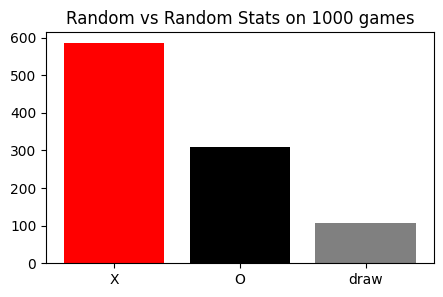

<Figure size 500x500 with 0 Axes>

In [84]:
# 1. Initialize the players
rand_player1 = RandomPlayer()
rand_player2 = RandomPlayer()

# 2. Play one game with verbose output
new_game = TicTacToe()
play_game(new_game, rand_player1, rand_player2, verbose=True)

# 3. Play multiple games to collect the statistics
results = collect_results(rand_player1, rand_player2, n_games=1000, verbose=False)

# 4. Plot the results
plt.title("Random vs Random Stats on 1000 games")
plt.bar(range(3), [results['X'], results['O'], results['draw']], color=['red', 'black', 'gray'])
plt.xticks(range(3), ['X', 'O', 'draw'])
plt.figure(figsize=(5, 5))
plt.show()

## [2] Reinforcement Learning

### Monte Carlo Method 🤹🏻

The fundamental idea underlying the Monte Carlo method is to use simulations to solve problems that cannot be easily solved analytically.
- **Model-Free**: Unlike other techniques, here we do not assume complete knowledge of the environment's dynamics. Monte Carlo methods require only `experience`, since it addresses uncertainty by `simulating` different possible sequences of events, often referred to as `trajectories`. This makes them particularly useful in situations where model information is difficult to obtain or unavailable.
- **Average Return**: For each sampled trajectory, the method observes the returns obtained by the agent. Returns represent the `cumulative rewards` obtained over the entire sequence of actions. Since different trajectories may result in different returns due to the `stochastic nature` of the environment, the method averages these returns over multiple samples.

  > Action-value function: $Q(s,a) = \frac{1}{N} \sum_{i=1}^{N} G_i(s,a)$
  
  Where $G_i(s,a)$ is the return obtained by the agent after performing action $a$ in state $s$ in the $i$-th sampled trajectory.

The Monte Carlo method is particularly well-suited in this context due to the following reasons:
1. **Limited State Space**: Tic-tac-toe has a finite and relatively small state space, making it feasible for the Monte Carlo method to explore and evaluate all possible states through random sampling. In fact, the more simulations we run, the more accurate our estimates will be. But of course, this comes at the cost of `computational complexity`.
2. **Episodic Nature**: Tic-tac-toe is an episodic task, meaning that each episode (the match) has a well-defined terminal state (win, lose, or draw). This allows us to use the `terminal reward` as a proxy for the value of all states visited in that episode. This approach contrasts with methods that update values or policies at each step within an episode and may result in a form of `delayed learning`, slowing down the adaptation process. However, this is not a problem in our case, since the game has very short trajectories.


#### Parameters
- **Exploration Rate**: $\epsilon$ represents the probability of choosing to explore the environment rather than exploit the current known information. In other words, it's the likelihood that the learning agent will make a random move instead of the move that seems best according to its current knowledge.
- **Discount Factor**: $\gamma$  is a number between 0 and 1 that represents the importance of future rewards compared to immediate rewards. A higher value places more emphasis on future rewards, while a lower value makes the agent more short-sighted, caring more about immediate rewards. In the Monte Carlo method, after each game, we want to update the value of each state encountered during the match. The reward that a state receives depends not only on the immediate reward but also on the rewards of all future states, discounted by this factor. 
  > State value update: $V(s) = V(s) + \alpha [G_t - V(s)]$
  
  > Return from state $s$ onward: $G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + ... = \sum_{k=0}^{\infty} \gamma^k R_{t+k+1}$
- **Learning Rate**: $\alpha$ is the learning rate, which determines the extent to which new information overrides old information. A higher value makes the agent more sensitive to new information, while a lower value makes it more conservative, relying more on past experience. In our case, we want to update the value of each state after each game, so we can set $\alpha = 1$.
  

In [ ]:
class MonteCarloPlayer(Player):

  def __init__(self, exploration_rate=0.1, discount_factor=0.9, exploration_decay=0.95):
    super().__init__()
    self.exploration_rate = exploration_rate
    self.discount_factor = discount_factor
    self.exploration_decay = exploration_decay

    self.state_values = {}  # To store the estimated values of states
    self.return_counts = {}  # To keep track of how many times each state was visited
    self.states_visited = []  # To record states visited in a game

  def make_move(self, game: TicTacToe):
    """Choose a move based on the current policy"""
    # 1. Get all empty spaces
    empty_spaces = [(row, col) for row in range(3) for col in range(3) if game.board[row][col] == ' ']
    
    # 2. Choose a move based on the current policy
    if random() < self.exploration_rate:
      # 2.1. Exploration: Choose a random empty space
      row, col = choice(empty_spaces)
    else:
      # 2.2. Exploitation: Choose the empty space with the highest estimated value
      # Get the estimated values of each empty space
      values = [self.state_values.get(self.get_state(game, row, col), 0) for row, col in empty_spaces]
      # Choose the empty space with the highest estimated value
      row, col = empty_spaces[np.argmax(values)]

    # 3. Make the move
    game.make_move(row, col)

  def update_state_values(self, winner):
    """Update the estimated values of states based on the winner of the game"""
    # 1. Go through the states visited in reverse order
    for state in reversed(self.states_visited):
      # 1.1. Update the return count
      self.return_counts[state] += 1
      # 1.2. Update the estimated value
      self.state_values[state] += (winner - self.state_values[state]) / self.return_counts[state]
      # 1.3. Update the winner based on the discount factor
      winner *= self.discount_factor

    # 2. Reset the states visited
    self.states_visited = []
